## Preprocess

a partir dos logs gerados pelo `perf` este script serve para: 

- parsear o csv e exportar
- fazer gráfico com matplotlib e exportar png


In [1]:
import re
import os
import glob2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!tree src/results

src/results
├── mandelbrot_omp
│   ├── elephant.csv
│   ├── elephant.log
│   ├── elephant.png
│   ├── full.csv
│   ├── full.log
│   ├── full.png
│   ├── seahorse.csv
│   ├── seahorse.log
│   ├── seahorse.png
│   ├── triple_spiral.csv
│   ├── triple_spiral.log
│   └── triple_spiral.png
├── mandelbrot_pth
│   ├── elephant.csv
│   ├── elephant.log
│   ├── elephant.png
│   ├── full.csv
│   ├── full.log
│   ├── full.png
│   ├── seahorse.csv
│   ├── seahorse.log
│   ├── seahorse.png
│   ├── triple_spiral.csv
│   ├── triple_spiral.log
│   └── triple_spiral.png
└── mandelbrot_seq
    ├── elephant.log
    ├── full.log
    ├── seahorse.log
    └── triple_spiral.log

3 directories, 28 files


## Sequencial

- parser dos logs para csv
- gráficos

In [5]:
mandelbrot_seq_logs = [f for f in glob2.glob("src/results/mandelbrot_seq/*.log", recursive=True)]

src/results/mandelbrot_seq/seahorse.log
Saving csv in src/results/mandelbrot_seq/seahorse.csv
Saving graph in src/results/mandelbrot_seq/seahorse.png
src/results/mandelbrot_seq/triple_spiral.log
Saving csv in src/results/mandelbrot_seq/triple_spiral.csv
Saving graph in src/results/mandelbrot_seq/triple_spiral.png
src/results/mandelbrot_seq/full.log
Saving csv in src/results/mandelbrot_seq/full.csv
Saving graph in src/results/mandelbrot_seq/full.png
src/results/mandelbrot_seq/elephant.log
Saving csv in src/results/mandelbrot_seq/elephant.csv
Saving graph in src/results/mandelbrot_seq/elephant.png


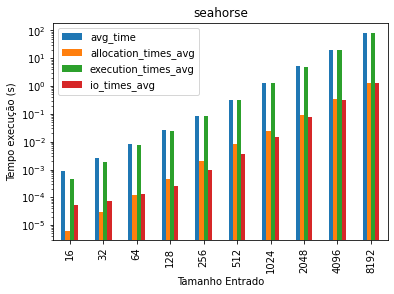

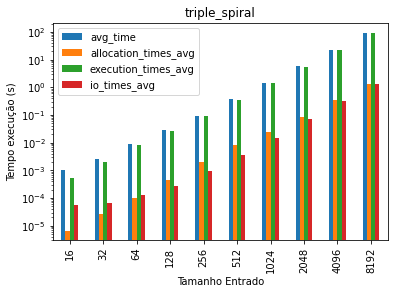

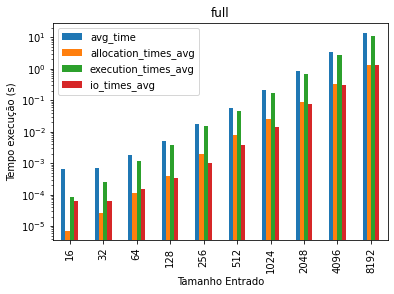

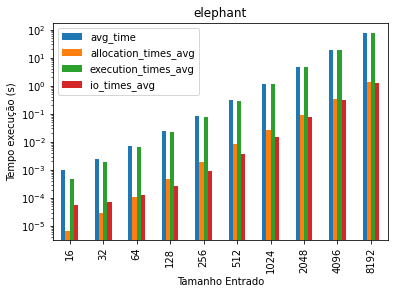

In [123]:
for path in mandelbrot_seq_logs:
    basename = os.path.basename(path).split('.')[0]
    dirname = os.path.dirname(path)
    print(path)

    with open(path, 'r') as file:
        log = file.read()

    # regex to extract lines with allocation, exec and io times
    raw_allocation_times = re.findall(".*Allocation time.*", log)
    raw_execution_times = re.findall(".*Execution time.*", log)
    raw_io_times = re.findall(".*O time.*", log)

    # regex to extract lines with times and sizes
    times = re.findall("\d.*?seconds", log)
    sizes = re.findall("\d* \d*' \(10 run", log)

    # create list with information and parse to avg and std time output from perf
    avg_time = [float(time.split(' ')[0].replace(',','.')) for time in times]
    std_time = [float(time.split(' ')[2].replace(',','.')) for time in times]
    sizes = [size.split(' ')[1].split("'")[0] for size in sizes]

    # create list with all times
    allocation_times = [float(time.split(":")[1].replace('s', '')) for time in raw_allocation_times]
    execution_times = [float(time.split(":")[1].replace('s', '')) for time in raw_execution_times]
    io_times = [float(time.split(":")[1].replace('s', '')) for time in raw_io_times]

    # calculate avg and std of variables
    allocation_times_avg = [np.average(allocation_times[i*10 : (i*10 + 10)]) for i in range(10)]
    allocation_times_std = [np.std(allocation_times[i*10 : (i*10 + 10)]) for i in range(10)]

    execution_times_avg = [np.average(execution_times[i*10 : (i*10 + 10)]) for i in range(10)]
    execution_times_std = [np.std(execution_times[i*10 : (i*10 + 10)]) for i in range(10)]

    io_times_avg = [np.average(io_times[i*10 : (i*10 + 10)]) for i in range(10)]
    io_times_std = [np.std(io_times[i*10 : (i*10 + 10)]) for i in range(10)]

    df = pd.DataFrame({
        'avg_time': pd.to_numeric(avg_time), 
        'std_time': pd.to_numeric(std_time),
        'sizes': pd.to_numeric(sizes), 
        'allocation_times_avg': pd.to_numeric(allocation_times_avg),
        'allocation_times_std': pd.to_numeric(allocation_times_std),
        'execution_times_avg': pd.to_numeric(execution_times_avg),
        'execution_times_std': pd.to_numeric(execution_times_std),
        'io_times_avg': pd.to_numeric(io_times_avg),
        'io_times_std': pd.to_numeric(io_times_std),
    })

    df.set_index('sizes', inplace=True)

    fig = df[[
        'avg_time', 
        'allocation_times_avg',
        'execution_times_avg',
        'io_times_avg',
    ]].plot(kind='bar', log=True, xlabel='Tamanho Entrado', ylabel='Tempo execução (s)', title=basename).get_figure()

    print('Saving csv in {}'.format(os.path.join(dirname, basename+'.csv')))
    df.to_csv(os.path.join(dirname, basename+'.csv'))

    print('Saving graph in {}'.format(os.path.join(dirname, basename+'.png')))
    fig.savefig(os.path.join(dirname, basename+'.png'))

## Paralelo - Pthreads e OpenMP

In [ ]:
mandelbrot_pth_logs = [f for f in glob2.glob("src/results/mandelbrot_pth/*.log", recursive=True)]
mandelbrot_omp_logs = [f for f in glob2.glob("src/results/mandelbrot_omp/*.log", recursive=True)]

In [7]:
def get_avg_std_time(path, export_csv=True, export_graph=True):
    
    basename = os.path.basename(path).split('.')[0]
    dirname = os.path.dirname(path)
    
    with open(path, 'r') as file:
        log = file.read()
    
    # regex to extract interest lines
    times = re.findall("\d.*?seconds", log)
    sizes_threads = re.findall("\d* \d*' \(10 run", log)

    # create list with information and parse
    avg_time = [float(time.split(' ')[0].replace(',','.')) for time in times]
    std_time = [float(time.split(' ')[2].replace(',','.')) for time in times]
    sizes = [size.split(' ')[0] for size in sizes_threads]
    threads = [thread.split(' ')[1].split("'")[0] for thread in sizes_threads]
    
    # create pandas dataframe
    df = pd.DataFrame({
        'avg_time': avg_time, 
        'std_time': std_time,
        'sizes': sizes, 
        'threads': threads, 
    })
    df.threads = pd.to_numeric(df.threads)
    df.sizes = pd.to_numeric(df.sizes)
    
    # export csv
    if export_csv:
        print('Saving csv in {}'.format(os.path.join(dirname, basename+'.csv')))
        df.to_csv(os.path.join(dirname, basename+'.csv'))
    
    # export graphs
#     if export_graph:
#         print('Saving graph in {}'.format(os.path.join(dirname, basename+'.png')))
#         export_graph(df, basename)
#         print(basename)

    return df

In [9]:
# paralell
for log in mandelbrot_omp_logs + mandelbrot_pth_logs: 
    path =  log
    print(path)
    basename = os.path.basename(path).split('.')[0]
    dirname = os.path.dirname(path)

    df = get_avg_std_time(path)

    labels = [2**i for i in range(4, 14)]

    # set heights of bars
    bars1 = df[df['threads'] == 1].avg_time.to_list()
    bars2 = df[df['threads'] == 2].avg_time.to_list()
    bars3 = df[df['threads'] == 4].avg_time.to_list()
    bars4 = df[df['threads'] == 8].avg_time.to_list()
    bars5 = df[df['threads'] == 16].avg_time.to_list()
    bars6 = df[df['threads'] == 32].avg_time.to_list()

    # men_std = [2, 3, 4, 1, 2]
    # women_std = [3, 5, 2, 3, 3]

    # set width of bars
    barWidth = 0.15

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]

    plt.figure()


    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='1', log=True)
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='2', log=True)
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='4', log=True)
    plt.bar(r4, bars4, width=barWidth, edgecolor='white', label='8', log=True)
    plt.bar(r5, bars5, width=barWidth, edgecolor='white', label='16', log=True)
    plt.bar(r6, bars6, width=barWidth, edgecolor='white', label='32', log=True)

    plt.xticks([r + barWidth for r in range(len(bars1))], labels)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel('Tempo Execução (s)')
    plt.xlabel('Tamanho')
    plt.title(basename)
    plt.legend()

    # plt.show()
    print('Saving graph in {}'.format(os.path.join(dirname, basename+'.png')))
    plt.savefig(os.path.join(dirname, basename + '.png'))
    plt.close()

src/results/mandelbrot_omp/seahorse.log
src/results/mandelbrot_omp/triple_spiral.log
src/results/mandelbrot_omp/full.log
src/results/mandelbrot_omp/elephant.log
src/results/mandelbrot_pth/seahorse.log
src/results/mandelbrot_pth/triple_spiral.log
src/results/mandelbrot_pth/full.log
src/results/mandelbrot_pth/elephant.log
